In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [ ]:
IMAGE_SIZE = 128
EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 1e-4

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print("="*70)
print("AI-DRIVEN BRAIN TUMOR SEGMENTATION")
print("="*70)
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print("="*70)

AI-DRIVEN BRAIN TUMOR SEGMENTATION
TensorFlow version: 2.19.0
GPU Available: False


In [ ]:
def normalize_image(image):
    """Normalize image to 0-1 range"""
    if np.max(image) > 0:
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return image

def preprocess_image(image, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """Resize and normalize an image"""
    image = cv2.resize(image, target_size)
    image = normalize_image(image)
    return image

def create_synthetic_data(num_samples=500):
    """
    Create synthetic brain tumor data for demonstration
    In production, replace this with actual BraTS data loading
    """
    print(f"\nCreating {num_samples} synthetic samples for demonstration...")

    X = np.random.rand(num_samples, IMAGE_SIZE, IMAGE_SIZE, 1).astype(np.float32)
    y = np.zeros((num_samples, IMAGE_SIZE, IMAGE_SIZE, 1), dtype=np.float32)

    # Add realistic tumor structures

In [ ]:
def normalize_image(image):
    """Normalize image to 0-1 range"""
    if np.max(image) > 0:
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return image

def preprocess_image(image, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """Resize and normalize an image"""
    image = cv2.resize(image, target_size)
    image = normalize_image(image)
    return image

def create_synthetic_data(num_samples=500):
    """
    Create synthetic brain tumor data for demonstration
    In production, replace this with actual BraTS data loading
    """
    print(f"\nCreating {num_samples} synthetic samples for demonstration...")

    X = np.random.rand(num_samples, IMAGE_SIZE, IMAGE_SIZE, 1).astype(np.float32)
    y = np.zeros((num_samples, IMAGE_SIZE, IMAGE_SIZE, 1), dtype=np.float32)

    # Add realistic tumor structures
    for i in range(num_samples):

        center_x = np.random.randint(IMAGE_SIZE//4, 3*IMAGE_SIZE//4)
        center_y = np.random.randint(IMAGE_SIZE//4, 3*IMAGE_SIZE//4)
        radius = np.random.randint(10, 30)

        cv2.circle(y[i, :, :, 0], (center_x, center_y), radius, 1, -1)

        tumor_region = y[i, :, :, 0] > 0
        X[i, tumor_region, 0] += np.random.rand(np.sum(tumor_region)) * 0.3

    return X, y

In [ ]:
def normalize_image(image):
    """Normalize image to 0-1 range"""
    if np.max(image) > 0:
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return image

def preprocess_image(image, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """Resize and normalize an image"""
    image = cv2.resize(image, target_size)
    image = normalize_image(image)
    return image

def create_synthetic_data(num_samples=500):
    """
    Create synthetic brain tumor data for demonstration
    In production, replace this with actual BraTS data loading
    """
    print(f"\nCreating {num_samples} synthetic samples for demonstration...")

    X = np.random.rand(num_samples, IMAGE_SIZE, IMAGE_SIZE, 1).astype(np.float32)
    y = np.zeros((num_samples, IMAGE_SIZE, IMAGE_SIZE, 1), dtype=np.float32)

    # Add realistic tumor structures
    for i in range(num_samples):

        center_x = np.random.randint(IMAGE_SIZE//4, 3*IMAGE_SIZE//4)
        center_y = np.random.randint(IMAGE_SIZE//4, 3*IMAGE_SIZE//4)
        radius = np.random.randint(10, 30)

        cv2.circle(y[i, :, :, 0], (center_x, center_y), radius, 1, -1)

        tumor_region = y[i, :, :, 0] > 0
        X[i, tumor_region, 0] += np.random.rand(np.sum(tumor_region)) * 0.3

    return X, y

In [ ]:
def conv_block(inputs, num_filters):
    """Convolutional block for U-Net"""
    x = layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

def encoder_block(inputs, num_filters):
    """Encoder block for U-Net"""
    x = conv_block(inputs, num_filters)
    p = layers.MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    """Decoder block for U-Net"""
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)):
    """Build U-Net model for brain tumor segmentation"""
    inputs = layers.Input(shape=input_shape)

In [ ]:
def conv_block(inputs, num_filters):
    """Convolutional block for U-Net"""
    x = layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

def encoder_block(inputs, num_filters):
    """Encoder block for U-Net"""
    x = conv_block(inputs, num_filters)
    p = layers.MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    """Decoder block for U-Net"""
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)):
    """Build U-Net model for brain tumor segmentation"""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

    model = models.Model(inputs, outputs, name='U-Net')
    return model

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Dice coefficient for measuring segmentation accuracy"""
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Dice loss function"""
    return 1 - dice_coefficient(y_true, y_pred)

def iou_score(y_true, y_pred, smooth=1e-6):
    """Intersection over Union (IoU) metric"""
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def combined_loss(y_true, y_pred):
    """Combined loss: Binary Cross-Entropy + Dice Loss"""
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

In [ ]:
def calculate_tumor_volume(mask, voxel_size=(1.0, 1.0, 1.0)):
    """
    Calculate tumor volume from segmentation mask

    Parameters:
    - mask: binary segmentation mask
    - voxel_size: tuple of (width, height, depth) in mm

    Returns:
    - volume in mm³ and cm³
    """
    tumor_voxels = np.sum(mask > 0.5)
    voxel_volume = voxel_size[0] * voxel_size[1] * voxel_size[2]
    volume_mm3 = tumor_voxels * voxel_volume
    volume_cm3 = volume_mm3 / 1000
    return volume_mm3, volume_cm3

def calculate_tumor_metrics(true_mask, pred_mask, voxel_size=(1.0, 1.0, 1.0)):
    """Calculate comprehensive tumor metrics"""
    # Volume calculations
    true_vol_mm3, true_vol_cm3 = calculate_tumor_volume(true_mask, voxel_size)
    pred_vol_mm3, pred_vol_cm3 = calculate_tumor_volume(pred_mask, voxel_size)

    # Volume error
    volume_error = abs(pred_vol_cm3 - true_vol_cm3)
    volume_error_pct = (volume_error / true_vol_cm3) * 100 if true_vol_cm3 > 0 else 0

    # Segmentation metrics
    dice = dice_coefficient(true_mask, pred_mask).numpy()
    iou = iou_score(true_mask, pred_mask).numpy()

    return {
        'true_volume_cm3': true_vol_cm3,
        'pred_volume_cm3': pred_vol_cm3,
        'volume_error_cm3': volume_error,
        'volume_error_pct': volume_error_pct,
        'dice_coefficient': dice,
        'iou_score': iou
    }


In [ ]:
def visualize_samples(images, masks, num_samples=5, save_path=None):
    """Visualize random samples from the dataset"""
    indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices):
        # Original image
        axes[i, 0].imshow(images[idx, :, :, 0], cmap='gray')
        axes[i, 0].set_title('MRI Image')
        axes[i, 0].axis('off')

        # Ground truth mask
        axes[i, 1].imshow(masks[idx, :, :, 0], cmap='jet')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        # Overlay
        axes[i, 2].imshow(images[idx, :, :, 0], cmap='gray')
        axes[i, 2].imshow(masks[idx, :, :, 0], cmap='jet', alpha=0.5)
        axes[i, 2].set_title('Overlay')
        axes[i, 2].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def visualize_predictions(images, true_masks, pred_masks, num_samples=5, save_path=None):
    """Visualize model predictions"""
    indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)

    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices):
        # Original image
        axes[i, 0].imshow(images[idx, :, :, 0], cmap='gray')
        axes[i, 0].set_title('MRI Image')
        axes[i, 0].axis('off')

        # Ground truth
        axes[i, 1].imshow(true_masks[idx, :, :, 0], cmap='jet')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        # Prediction
        axes[i, 2].imshow(pred_masks[idx, :, :, 0], cmap='jet')
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')

        # Overlay
        axes[i, 3].imshow(images[idx, :, :, 0], cmap='gray')
        axes[i, 3].imshow(pred_masks[idx, :, :, 0], cmap='jet', alpha=0.5)
        axes[i, 3].set_title('Prediction Overlay')
        axes[i, 3].axis('off')

        # Calculate Dice score
        dice = dice_coefficient(true_masks[idx:idx+1], pred_masks[idx:idx+1]).numpy()
        axes[i, 0].text(0.5, -0.1, f'Dice: {dice:.4f}',
                       transform=axes[i, 0].transAxes, ha='center', fontweight='bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def plot_training_history(history, save_path=None):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Dice Coefficient
    axes[0, 1].plot(history.history['dice_coefficient'], label='Train Dice')
    axes[0, 1].plot(history.history['val_dice_coefficient'], label='Val Dice')
    axes[0, 1].set_title('Dice Coefficient')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice Coefficient')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # IoU Score
    axes[1, 0].plot(history.history['iou_score'], label='Train IoU')
    axes[1, 0].plot(history.history['val_iou_score'], label='Val IoU')
    axes[1, 0].set_title('IoU Score')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('IoU Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Accuracy
    axes[1, 1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[1, 1].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[1, 1].set_title('Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def plot_clinical_metrics(metrics_df, save_path=None):
    """Visualize clinical metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Volume comparison
    axes[0, 0].scatter(metrics_df['true_volume_cm3'], metrics_df['pred_volume_cm3'], alpha=0.6)
    axes[0, 0].plot([0, metrics_df['true_volume_cm3'].max()], [0, metrics_df['true_volume_cm3'].max()],
                    'r--', label='Perfect Prediction')
    axes[0, 0].set_xlabel('True Volume (cm³)')
    axes[0, 0].set_ylabel('Predicted Volume (cm³)')
    axes[0, 0].set_title('Tumor Volume: True vs Predicted')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Volume error distribution
    axes[0, 1].hist(metrics_df['volume_error_pct'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Volume Error (%)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Volume Prediction Error')
    axes[0, 1].axvline(metrics_df['volume_error_pct'].mean(), color='red',
                       linestyle='--', label=f'Mean: {metrics_df["volume_error_pct"].mean():.2f}%')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Dice coefficient distribution
    axes[1, 0].hist(metrics_df['dice_coefficient'], bins=30, edgecolor='black', alpha=0.7, color='green')
    axes[1, 0].set_xlabel('Dice Coefficient')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Dice Coefficients')
    axes[1, 0].axvline(metrics_df['dice_coefficient'].mean(), color='red',
                       linestyle='--', label=f'Mean: {metrics_df["dice_coefficient"].mean():.4f}')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # IoU score distribution
    axes[1, 1].hist(metrics_df['iou_score'], bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[1, 1].set_xlabel('IoU Score')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of IoU Scores')
    axes[1, 1].axvline(metrics_df['iou_score'].mean(), color='red',
                       linestyle='--', label=f'Mean: {metrics_df["iou_score"].mean():.4f}')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def generate_clinical_report(metrics_df):
    """Generate a comprehensive clinical report"""
    pass


STEP 1: DATA PREPARATION

Creating 500 synthetic samples for demonstration...

Training set: 350 samples
Validation set: 75 samples
Test set: 75 samples

Visualizing sample images...


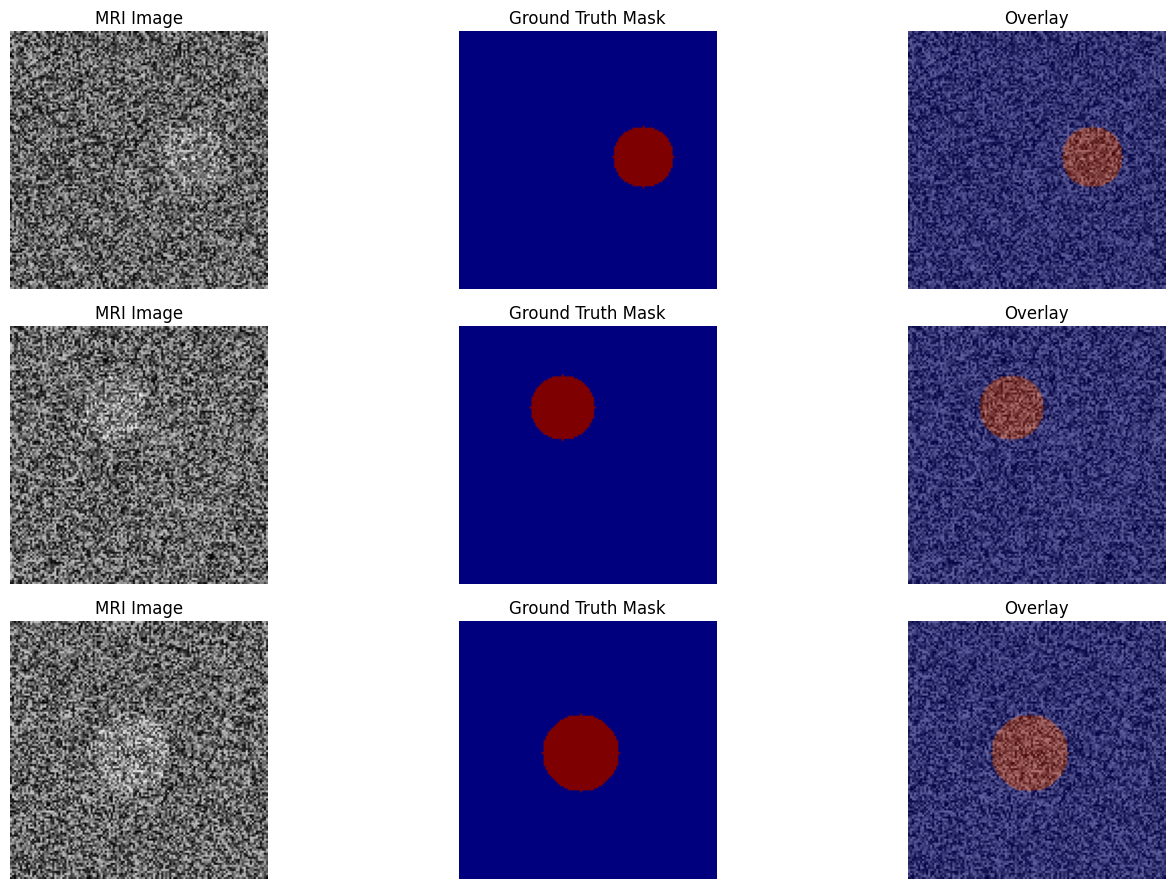


STEP 2: MODEL BUILDING

Model architecture created successfully!
Total parameters: 31,054,145
Model compiled successfully!

STEP 3: MODEL TRAINING
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.9288 - dice_coefficient: 0.2335 - iou_score: 0.1383 - loss: 1.0681 
Epoch 1: val_dice_coefficient improved from -inf to 0.13223, saving model to best_brain_tumor_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 735s 33s/step - accuracy: 0.9298 - dice_coefficient: 0.2389 - iou_score: 0.1422 - loss: 1.0600 - val_accuracy: 0.9445 - val_dice_coefficient: 0.1322 - val_iou_score: 0.0709 - val_loss: 1.5373 - learning_rate: 1.0000e-04
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.9875 - dice_coefficient: 0.5765 - iou_score: 0.4065 - loss: 0.5475 
Epoch 2: val_dice_coefficient did not improve from 0.13223
22/22 ━━━━━━━━━━━━━━━━━━━━ 742s 34s/step - accuracy: 0.9876 - dice_coefficient: 0.5781 - iou_score: 0.4082 - loss: 0.5453 - val_accuracy: 0.9265 - val_dice_coefficient: 0.1295 - val_iou_score: 0.0693 - val_loss: 1.4468 - learning_rate: 1.0000e-04
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.9903 - dice_coefficient: 0.6847 - iou_score: 0.5216 - loss: 0.3950 
Epoch 3: val_dice_coefficient did not improve from 0.13223
22/22 ━━━━━━━━━━━━━━━━━━━━ 727s 33s/step - accuracy: 0.9904 - dice_coefficient: 0.6856 - iou_score: 0.5226 - loss: 0.3939 - 

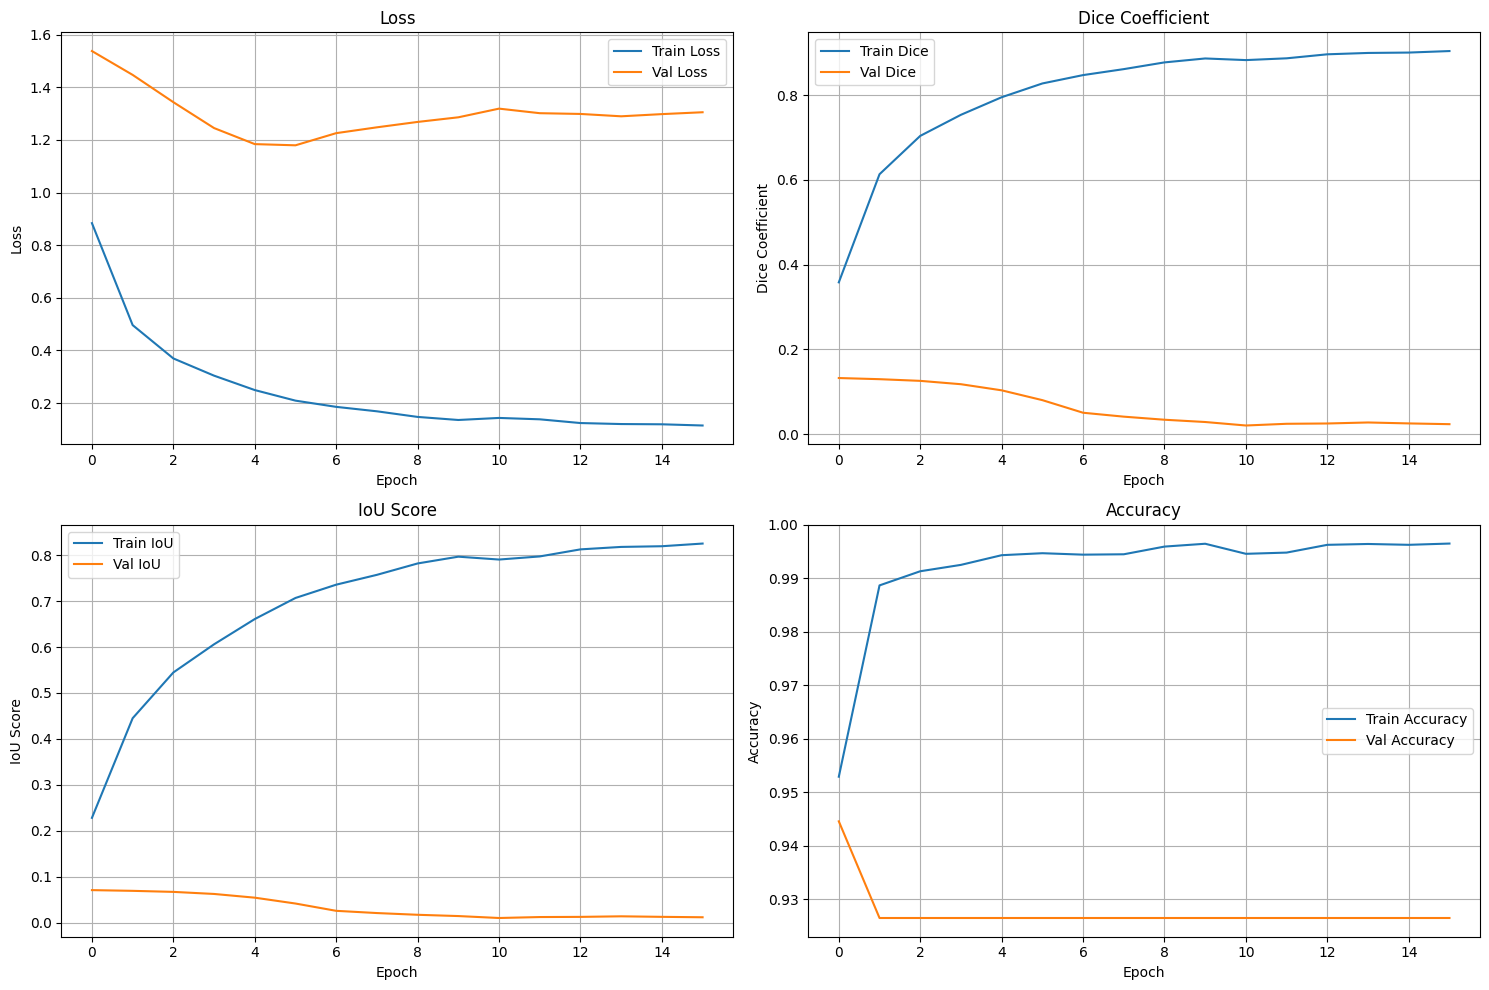


STEP 4: MODEL EVALUATION

TEST SET RESULTS:
  Test Loss: 1.5246
  Test Dice Coefficient: 0.1427
  Test IoU Score: 0.0768
  Test Accuracy: 0.9410

Generating predictions...

Visualizing predictions...


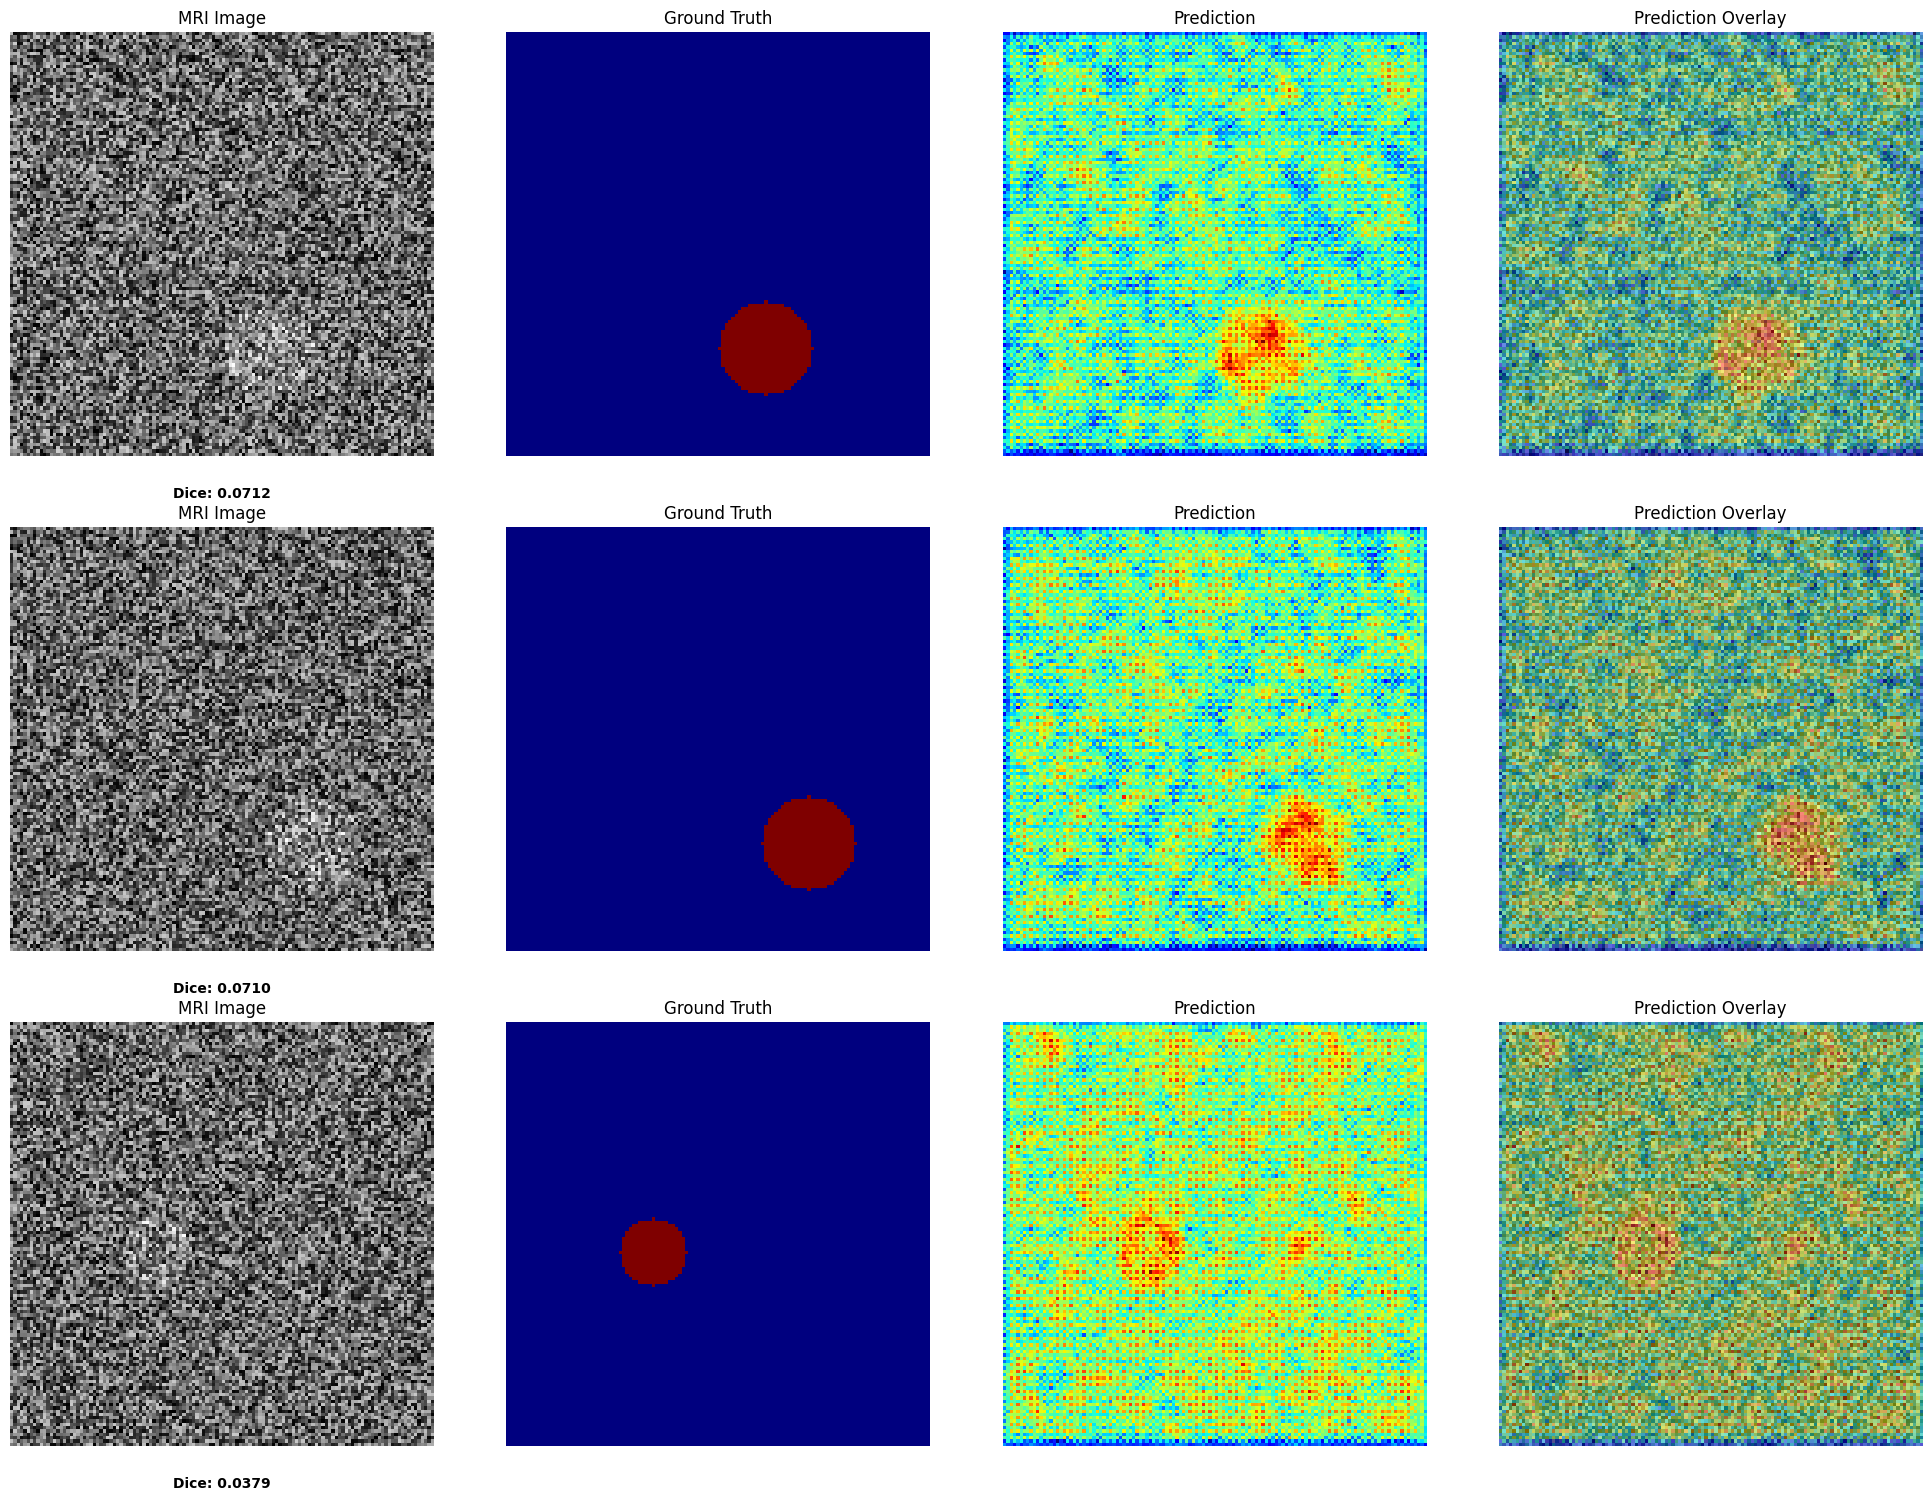


STEP 5: CLINICAL METRICS ANALYSIS

Calculating clinical metrics...

Plotting clinical metrics...


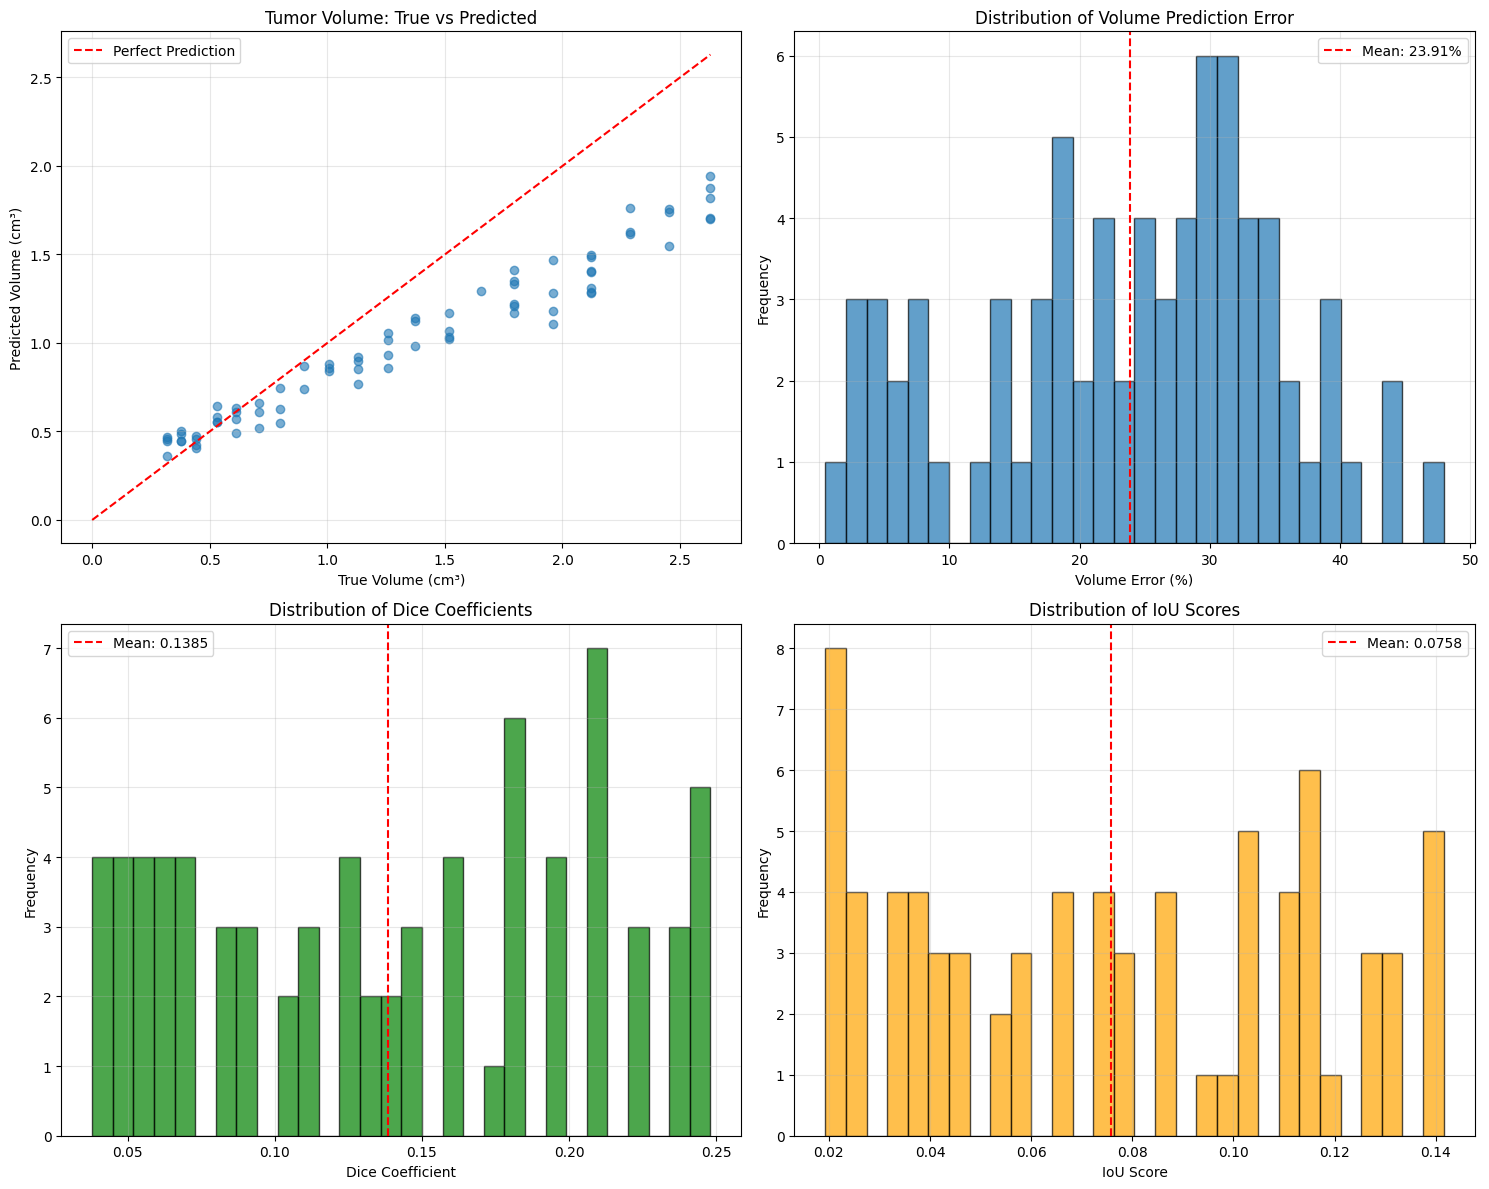


Metrics saved to 'tumor_segmentation_metrics.csv'

ANALYSIS COMPLETE!

Files generated:
  - best_brain_tumor_model.h5 (trained model)
  - tumor_segmentation_metrics.csv (clinical metrics)


In [ ]:
def main():
    """Main execution function"""

    print("\n" + "="*70)
    print("STEP 1: DATA PREPARATION")
    print("="*70)

    # Create or load data
    X, y = create_synthetic_data(num_samples=500)

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    print(f"\nTraining set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    # Visualize samples
    print("\nVisualizing sample images...")
    visualize_samples(X_train, y_train, num_samples=3)

    print("\n" + "="*70)
    print("STEP 2: MODEL BUILDING")
    print("="*70)

    # Build model
    model = build_unet()
    print("\nModel architecture created successfully!")
    print(f"Total parameters: {model.count_params():,}")

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=combined_loss,
        metrics=[dice_coefficient, iou_score, 'accuracy']
    )
    print("Model compiled successfully!")

    print("\n" + "="*70)
    print("STEP 3: MODEL TRAINING")
    print("="*70)

    # Define callbacks
    checkpoint = ModelCheckpoint(
        'best_brain_tumor_model.h5',
        monitor='val_dice_coefficient',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_dice_coefficient',
        mode='max',
        patience=15,
        verbose=1,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        verbose=1
    )

    print("\nTraining completed!")

    # Plot training history
    print("\nPlotting training history...")
    plot_training_history(history)

    print("\n" + "="*70)
    print("STEP 4: MODEL EVALUATION")
    print("="*70)

    # Evaluate on test set
    test_results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)

    print("\nTEST SET RESULTS:")
    print(f"  Test Loss: {test_results[0]:.4f}")
    print(f"  Test Dice Coefficient: {test_results[1]:.4f}")
    print(f"  Test IoU Score: {test_results[2]:.4f}")
    print(f"  Test Accuracy: {test_results[3]:.4f}")

    # Make predictions
    print("\nGenerating predictions...")
    y_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

    # Visualize predictions
    print("\nVisualizing predictions...")
    visualize_predictions(X_test, y_test, y_pred, num_samples=3)

    print("\n" + "="*70)
    print("STEP 5: CLINICAL METRICS ANALYSIS")
    print("="*70)

    # Calculate clinical metrics
    print("\nCalculating clinical metrics...")
    all_metrics = []
    for i in range(len(X_test)):
        metrics = calculate_tumor_metrics(y_test[i:i+1], y_pred[i:i+1])
        all_metrics.append(metrics)

    metrics_df = pd.DataFrame(all_metrics)

    # Plot clinical metrics
    print("\nPlotting clinical metrics...")
    plot_clinical_metrics(metrics_df)

    # Generate clinical report
    generate_clinical_report(metrics_df)

    # Save metrics to CSV
    metrics_df.to_csv('tumor_segmentation_metrics.csv', index=False)
    print("\nMetrics saved to 'tumor_segmentation_metrics.csv'")

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE!")
    print("="*70)
    print("\nFiles generated:")
    print("  - best_brain_tumor_model.h5 (trained model)")
    print("  - tumor_segmentation_metrics.csv (clinical metrics)")

    return model, history, metrics_df

if __name__ == "__main__":
    # Run the complete pipeline
    model, history, metrics_df = main()